In [68]:
import tensorflow as tf
import numpy as np 
import pickle
from pathlib import Path
import gym 
import matplotlib
import time
import os

from utils import Logger, MasterBuffer, Network
from policy import Policy
from density import DensityModel

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class DynamicsModel(object):
    def __init__(self, graph_args, rollout_args):
        self.enc_dim = graph_args['enc_dim']
        self.act_dim = graph_args['act_dim']
        self.act_low = graph_args['action_low']
        self.act_high = graph_args['action_high']
        
        self.learning_rate = graph_args['learning_rate']
        # network params
        self.hid_size = graph_args['hid_size']
        self.n_hidden = graph_args['n_hidden']
        self.conv_depth = graph_args['conv_depth']
        # rollout args
        self.horizon = rollout_args['horizon']
        self.num_rollouts = rollout_args['num_rollouts']
        
        self.state, self.action, self.n_state = self.setup_placeholders()
        self.n_state_pred = self.dynamics_func(self.state, self.action, False)
        
        # Calculate Loss
        delta = self.state - self.n_state
        delta_pred = self.state - self.n_state_pred
        self.loss = tf.losses.mean_squared_error(delta, delta_pred)
        self.update_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

    def set_session(self, sess):
        self.sess = sess

    def setup_placeholders(self):
        state = tf.placeholder(shape=(None, self.enc_dim), name="state", dtype=tf.float32)
        action = tf.placeholder(shape=(None, self.act_dim), name='action', dtype=tf.float32)
        n_state = tf.placeholder(shape=(None, self.enc_dim), name="next_state", dtype=tf.float32)
        return state, action, n_state

    def dynamics_func(self, state, action, reuse):
        # add state, action normalization?
        sa = tf.concat([state, action], axis=1)
        delta_pred = Network(sa, self.enc_dim, 'dynamics', self.hid_size, conv_depth=0, n_hidden_dense=self.n_hidden, reuse=reuse)
        n_state_pred = state + delta_pred
        return n_state_pred    
    
    def update(self, state, action, n_state):
        loss, _ = self.sess.run([self.loss, self.update_step], feed_dict={
            self.state: state,
            self.action: action,
            self.n_state: n_state
        })
        return loss

    def get_best_actions(self, state, profit_fcn, num_actions):
        """ Given encoded state will return `num_rollouts` rollouts where each rollout is of size `horizon`.
        Encoded state.
        => rollouts 
        => apply profit_fcn to rollouts 
        => choose rollout with highest profit 
        => return (first k-actions of best rollout, profit of rollout)
        """
        ran_sample = tf.random_uniform((self.horizon, self.num_rollouts, self.act_dim), 
                                       minval=self.act_low, 
                                       maxval=self.act_high, 
                                       dtype=tf.int32)
        
        rollout_profits = np.zeros((self.num_rollouts,), dtype=np.float32)
        
        # init state batch to starting state
        state_batch = tf.ones((self.num_rollouts, 1), dtype=tf.float32) * state
        for index in range(self.horizon):
            act_batch = tf.cast(ran_sample[index], tf.float32)
            next_state_batch = self.dynamics_func(state_batch, act_batch, True)
            state_batch = next_state_batch
            
            # check profit of current states for all rollouts 
            profit_batch = profit_fcn(state_batch, evaluate=True, encoded=True)
            rollout_profits += profit_batch
            
        max_profit_rollout = np.argmax(rollout_profits, axis=0)
        ran_sample = tf.transpose(ran_sample, perm=(1, 0, 2))
        best_actions = ran_sample[max_profit_rollout][:num_actions]
        return best_actions, rollout_profits[max_profit_rollout]

In [3]:
# # most params are default taken from homework
# env = gym.make('MontezumaRevenge-v0')

# ## STATE DENSITY FUNCTION PARAMS
# density_graph_args = {
#     'ob_dim': env.observation_space.shape,
#     'learning_rate': 5e-3,
#     'z_size': 32,
#     'kl_weight': 1e-2,
#     'conv_depth': 5,
#     'hid_size': 32,
#     'n_hidden': 2,
#     'bonus_multiplier': 1
# }

# ## POLICY PARAMS
# policy_graph_args = {
#     'ob_dim': env.observation_space.shape,
#     'act_dim': env.action_space.n,
#     'clip_range': 0.2,
#     'conv_depth': 5,
#     'filter_size': 32,
#     'learning_rate': 5e-3,
#     'num_target_updates': 10,
#     'num_grad_steps_per_target_update': 10
# }
# adv_args = {
#     'gamma': 0.9999999
# }

# ## STATE DYNAMICS PARAMS
# action_low = 0
# action_high = env.action_space.n
# dynamics_graph_args = {
#     'ob_dim': env.observation_space.shape,
#     'act_dim': env.action_space.n,
#     'action_low': action_low,
#     'action_high': action_high,
#     'learning_rate': 1e-3,
#     'hid_size': 250,
#     'n_hidden': 2
# }
# dynamics_rollout_args = {
#     'horizon': 30,
#     'num_rollouts': 1000,
# }

# ## AGENT PARAMS
# agent_args = {
#     'density_train_itr': 200,
# }

In [4]:
# tf.reset_default_graph()
# # models
# policy = Policy(policy_graph_args, adv_args)
# density_model = DensityModel(density_graph_args)
# dynamics_model = DynamicsModel(dynamics_graph_args, dynamics_rollout_args)
# # utils # SmallRAMProblems
# replay_buffer = MasterBuffer(max_size=40000)
# logger = Logger()
# # agent which will do all the work
# agent = Agent(env, policy, density_model, dynamics_model, replay_buffer, logger, agent_args)

In [5]:
class Agent(object):
    def __init__(self, env, policy, density, dynamics, replay_buffer, logger, args):
        self.env = env
        # Models
        self.policy = policy
        self.density = density
        self.dynamics = dynamics
        # Utils
        self.replay_buffer = replay_buffer
        self.logger = logger
        # Args
        self.density_train_itr = args['density_train_itr']
        self.dynamics_train_itr = args['dynamics_train_itr']
        self.num_actions_taken_conseq = args['num_actions_taken_conseq']
        self.profit_fcn = self.density.get_bonus
        
    def set_session(self, sess):
        self.sess = sess
        self.policy.set_session(sess)
        self.density.set_session(sess)
        self.dynamics.set_session(sess)
        
    def sample_env(self, batch_size, num_samples, shuffle, action_selection):
        obs = self.env.reset()
        actions = []
        taking_action = False
        
        for _ in range(num_samples):
            if action_selection == 'random':
                act = self.env.action_space.sample()
            elif action_selection == 'algorithm':
                if not taking_action:
                    actions = self.get_action(obs, self.num_actions_taken_conseq)
                    action_index, taking_action = 0, True
                act = actions[action_index][0]
                action_index += 1
                # check for end of actions
                if action_index == self.num_actions_taken_conseq: taking_action = False
            # execute action and record
            n_ob, rew, done, _ = env.step(act)
            self.replay_buffer.record(obs, act, rew, n_ob, done)
            obs = n_ob if not done else env.reset()
        
        # get logprobs of taking actions w.r.t current policy
        obs, actions = self.replay_buffer.get_actions()
        logprobs = sess.run(policy.logprob, feed_dict={
            policy.obs: obs,
            policy.act: actions
        })
        self.replay_buffer.set_logprobs(logprobs)
        self.replay_buffer.merge_temp()
        return self.replay_buffer.get_all(batch_size, master=False, shuffle=shuffle)
        
    def get_action(self, obs, num_actions):
        # Encode observation from density encoder
        enc_obs = self.density.get_encoding([obs])[0]
        # get action from state dynamics
        actions, profit = self.dynamics.get_best_actions(enc_obs, self.profit_fcn, num_actions)
        # AFTER TESTING ====> if profit < eps:  actions = policy.get_actions()
        logger.log('dynamics', ['max_profit'], [profit])
        return actions.eval()
        
    def get_data(self, batch_size, num_samples, itr):
        if itr < 6:
            return self.sample_env(batch_size, num_samples, shuffle=True, action_selection='random')
        elif np.random.randint(10) < 6:
            return self.sample_env(batch_size, num_samples, shuffle=True, action_selection='algorithm')
        else:
            return self.replay_buffer.get_all(batch_size, master=True, shuffle=True, size=num_samples)
    
    def train(self, batch_size, num_samples, itr):
        obsList, actsList, rewardsList, n_obsList, donesList, logprobsList = self.get_data(batch_size, num_samples, itr)
        self.replay_buffer.flush_temp()
        
        # process in batches of data
        for obs, acts, rewards, n_obs, dones, logprobs in zip(obsList, actsList, rewardsList, n_obsList, donesList, logprobsList):
            # train density model
            for _ in range(self.density_train_itr):
                s1, s2, target = self.replay_buffer.get_density_batch(obs, batch_size)
                ll, kl, elbo = self.density.update(s1, s2, target)
                self.logger.log('density', ['logloss', 'kl', 'elbo'], [ll, kl, elbo])
                
            # update dynamics 
            for _ in range(self.dynamics_train_itr):
                # encode states
                enc_obs = self.density.get_encoding(obs)
                enc_n_obs = self.density.get_encoding(n_obs)
                acts = acts.reshape(acts.shape[0], 1)
                loss = self.dynamics.update(enc_obs, acts, enc_n_obs)
                self.logger.log('dynamics', ['loss'], [loss])
            
            # train critic & actor
            # inject exploration bonus
#             rewards = self.density.modify_reward(obs, rewards)
#             critic_loss = self.policy.train_critic(obs, n_obs, rewards, dones)
#             adv = self.policy.estimate_adv(obs, rewards, n_obs, dones)
#             actor_loss = self.policy.train_actor(obs, acts, logprobs, adv)
#             self.logger.log('policy', ['actor_loss', 'critic_loss'], [actor_loss, critic_loss])

# Test State Dynamics

In [6]:
env = gym.make('MontezumaRevenge-v0')

/home/brennan/anaconda2/envs/py3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [7]:
tf.reset_default_graph()

## POLICY PARAMS
policy_graph_args = {
    'ob_dim': env.observation_space.shape,
    'act_dim': env.action_space.n,
    'clip_range': 0.2,
    'conv_depth': 5,
    'filter_size': 32,
    'learning_rate': 5e-3,
    'num_target_updates': 10,
    'num_grad_steps_per_target_update': 10
}
adv_args = {
    'gamma': 0.9999999
}

## STATE DENSITY FUNCTION PARAMS
density_graph_args = {
    'ob_dim': env.observation_space.shape,
    'learning_rate': 5e-3,
    'z_size': 32,
    'kl_weight': 1e-2,
    'conv_depth': 5,
    'hid_size': 32,
    'n_hidden': 2,
    'bonus_multiplier': 1
}

# STATE DYNAMICS PARAMS
action_low = 0
action_high = env.action_space.n
dynamics_graph_args = {
    'enc_dim': density_graph_args['z_size'],
    'act_dim': 1,
    'action_low': action_low,
    'action_high': action_high,
    'learning_rate': 1e-3,
    'hid_size': 64,
    'conv_depth': 4,
    'n_hidden': 2
}
dynamics_rollout_args = {
    'horizon': 30,
    'num_rollouts': 1000,
}

## AGENT PARAMS
agent_args = {
    'density_train_itr': 200,
    'dynamics_train_itr': 10,
    'num_actions_taken_conseq': 5,
}

policy = Policy(policy_graph_args, adv_args)
dynamics = DynamicsModel(dynamics_graph_args, dynamics_rollout_args)
density = DensityModel(density_graph_args)

replay_buffer = MasterBuffer(max_size=30000)
logger = Logger()
agent = Agent(env, policy, density, dynamics, replay_buffer, logger, agent_args)

In [8]:
tf_config = tf.ConfigProto(inter_op_parallelism_threads=1, intra_op_parallelism_threads=1)
tf_config.gpu_options.allow_growth = True
with tf.Session(config=tf_config) as sess:
    sess.run(tf.global_variables_initializer())
    agent.set_session(sess)
    
    n_iter = 5
    num_samples = 256
    batch_size = [32]
    render_n = 6
    
    print('starting to train...')
    for bs in batch_size:
        for itr in range(n_iter):
            start = time.time()
            agent.train(bs, num_samples, itr)
            end = time.time()
            
            print('completed itr {} in {}sec...\r'.format(str(itr), int(end-start)), end="", flush=True)
            if itr == n_iter-1:
                logger.export()
                print('Exported logs...')

starting to train...
Exported logs...in 309sec...


# Viewing Party

In [15]:
logger = Logger()
logger.import_logs('zsize-32.pkl')
# logger.import_logs('1547598997.4943233.pkl')

In [16]:
density_loss = logger.logs['density']['logloss']
dynamics_loss = logger.logs['dynamics']['loss']
dynamics_max_profit = logger.logs['dynamics']['max_profit']

In [17]:
import matplotlib.pyplot as plt

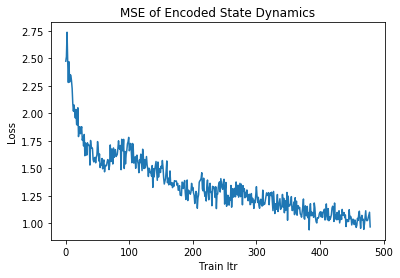

In [18]:
plt.plot(np.array(dynamics_loss).flatten())
plt.title('MSE of Encoded State Dynamics')
plt.ylabel('Loss')
plt.xlabel('Train Itr')
plt.show()

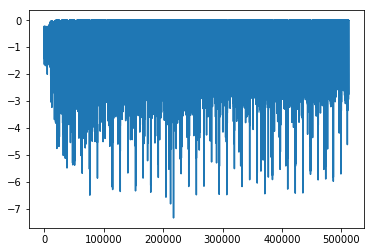

In [13]:
plt.plot(np.array(density_loss).flatten())
plt.show()

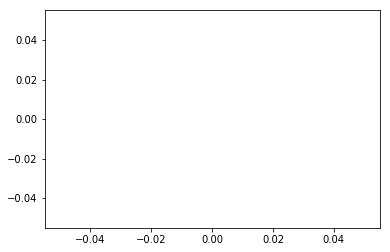

In [14]:
plt.plot(np.array(dynamics_max_profit).flatten())
plt.show()

In [ ]:
logs = list(Path('iter-frames').iterdir())
logs

In [ ]:
n_frames = 50
for fn in reversed(logs):
    if os.path.isfile(fn):
        with open(fn, 'rb') as file:
            frames = pickle.load(file)
    #         frames, rewards = data[0], data[1]
            # View 
            img = plt.imshow(frames[0])
            plt.title('Iteration:' + str(fn))
            for i, frame in enumerate(frames):
                img.set_data(frame) # just update the data
                display.display(plt.gcf())
                display.clear_output(wait=True)
                if i > n_frames: break

In [28]:
ones = tf.placeholder(shape=(5,5), dtype=tf.int32)
twos = ones + 1

with tf.Session() as sess:
    my_ones = tf.ones((5, 5), dtype=tf.int32)
    my_twos = sess.run(twos, feed_dict={
        ones: my_ones.eval()
    })